In [47]:
import sys

sys.path.append('../../MembraneQuant')
from membranequant import *
import seaborn as sns

%matplotlib notebook

### Import data

In [11]:
wt_pol_basepaths = ['/Users/blandt/Desktop/RING lines/Experiment/211106_nwg325_tom4,15,60',
               '/Users/blandt/Desktop/RING lines/Experiment/211112_nwg325_tom4,15,60']
wt_uni_basepaths = ['/Users/blandt/Desktop/Rundowns/Experiment/211113_nwg201_wt_tom4,15,60',
               '/Users/blandt/Desktop/Rundowns/Experiment/211117_nwg201_wt_tom4,15,60']

gcn4_pol_basepaths = ['/Users/blandt/Desktop/Analysis/Experiments/e2107__gcn4/210722_nwg376_tom4,15,60',
                 '/Users/blandt/Desktop/Analysis/Experiments/e2107__gcn4/210722_nwg377_tom4,15,60']
gcn4_uni_basepaths = '/Users/blandt/Desktop/Analysis/Experiments/e2112__gcn4_par3_mutant/211209_nwg347_lon_tom4,15,60'

In [12]:
wt_pol_paths = direcslist(wt_pol_basepaths)
wt_uni_paths = direcslist(wt_uni_basepaths)
gcn4_pol_paths = direcslist(gcn4_pol_basepaths)
gcn4_uni_paths = direcslist(gcn4_uni_basepaths)

In [13]:
wt_pol_imgs = [load_image(p + '/af_corrected.tif') for p in wt_pol_paths]
wt_uni_imgs = [load_image(p + '/af_corrected.tif') for p in wt_uni_paths]
gcn4_pol_imgs = [load_image(p + '/af_corrected.tif') for p in gcn4_pol_paths]
gcn4_uni_imgs = [load_image(p + '/af_corrected.tif') for p in gcn4_uni_paths]

In [14]:
wt_pol_rois = [np.loadtxt(p + '/ROI_fit.txt') for p in wt_pol_paths]
wt_uni_rois = [np.loadtxt(p + '/ROI_fit.txt') for p in wt_uni_paths]
gcn4_pol_rois = [np.loadtxt(p + '/ROI_fit.txt') for p in gcn4_pol_paths]
gcn4_uni_rois = [np.loadtxt(p + '/ROI_fit.txt') for p in gcn4_uni_paths]

### Images

In [15]:
wt_pol_rot = [rotated_embryo(i, r, 300, 200, 3) for i, r in zip(wt_pol_imgs, wt_pol_rois)]
wt_uni_rot = [rotated_embryo(i, r, 300, 200, 3) for i, r in zip(wt_uni_imgs, wt_uni_rois)]
gcn4_pol_rot = [rotated_embryo(i, r, 300, 200, 3) for i, r in zip(gcn4_pol_imgs, gcn4_pol_rois)]
gcn4_uni_rot = [rotated_embryo(i, r, 300, 200, 3) for i, r in zip(gcn4_uni_imgs, gcn4_uni_rois)]

<IPython.core.display.Javascript object>


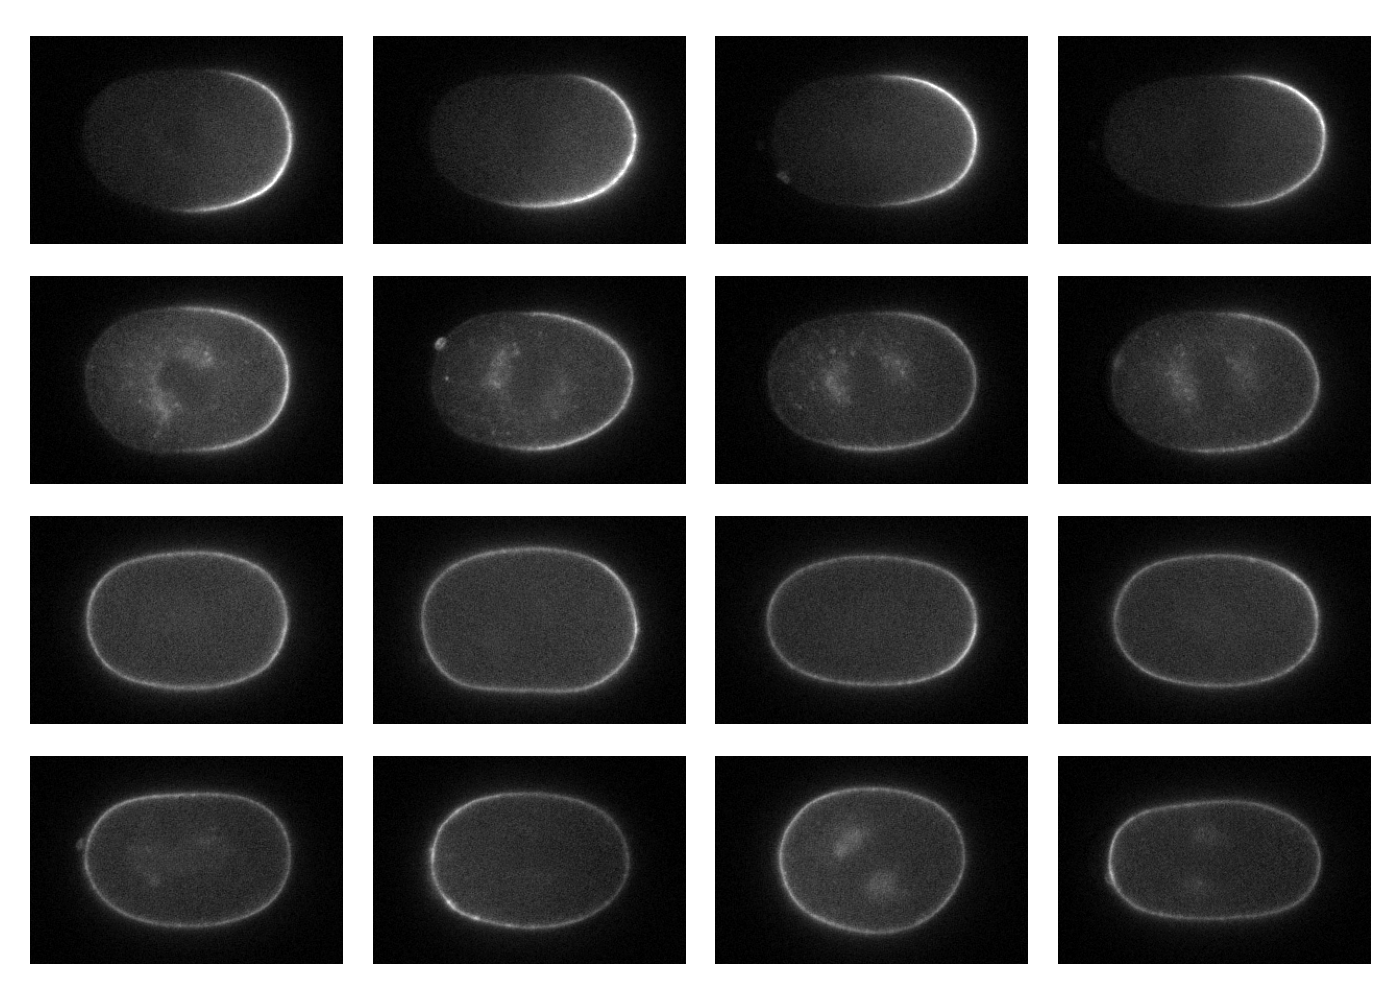

In [223]:
fig, ax = plt.subplots(4, 4)

vmin = 0
vmax = 25000
cmap = 'gray'

[ax[0][i].imshow(img, cmap=cmap, vmin=vmin, vmax=vmax) for i, img in enumerate(wt_pol_rot[:4])]
[ax[1][i].imshow(img, cmap=cmap, vmin=vmin, vmax=vmax) for i, img in enumerate(gcn4_pol_rot[:4])]
[ax[2][i].imshow(img, cmap=cmap, vmin=vmin, vmax=vmax) for i, img in enumerate(wt_uni_rot[:4])]
[ax[3][i].imshow(img, cmap=cmap, vmin=vmin, vmax=vmax) for i, img in enumerate(gcn4_uni_rot[:4])]

[[ax[i][j].axis('off') for i in range(4)] for j in range(4)]

fig.set_size_inches(7,5)
fig.tight_layout()
fig.savefig('Figs uni/examples.png', dpi=600, transparent=True)

### Quantification

In [84]:
imgs_all = wt_pol_imgs + wt_uni_imgs + gcn4_pol_imgs + gcn4_uni_imgs 
rois_all = wt_pol_rois + wt_uni_rois + gcn4_pol_rois + gcn4_uni_rois 
conditions = ['wt_pol'] * len(wt_pol_imgs) + ['wt_uni'] * len(wt_uni_imgs) + ['gcn4_pol'] * len(gcn4_pol_imgs) + ['gcn4_uni'] * len(gcn4_uni_imgs)
cytbg = np.loadtxt('../GCN4 PAR-2/cyt_profile.txt')
membg = np.loadtxt('../PAR-2 RING MUTANTS/mem_profile.txt')

In [85]:
iq = ImageQuant(img=imgs_all, cytbg=cytbg, membg=membg, roi=rois_all, uni_cyt=True, descent_steps=200, iterations=1, 
                rol_ave=5, lr=0.002, interp_type='linear')

In [86]:
iq.run()

100%|██████████| 200/200 [00:15<00:00, 12.69it/s]


Time elapsed: 16.63 seconds 


<IPython.core.display.Javascript object>


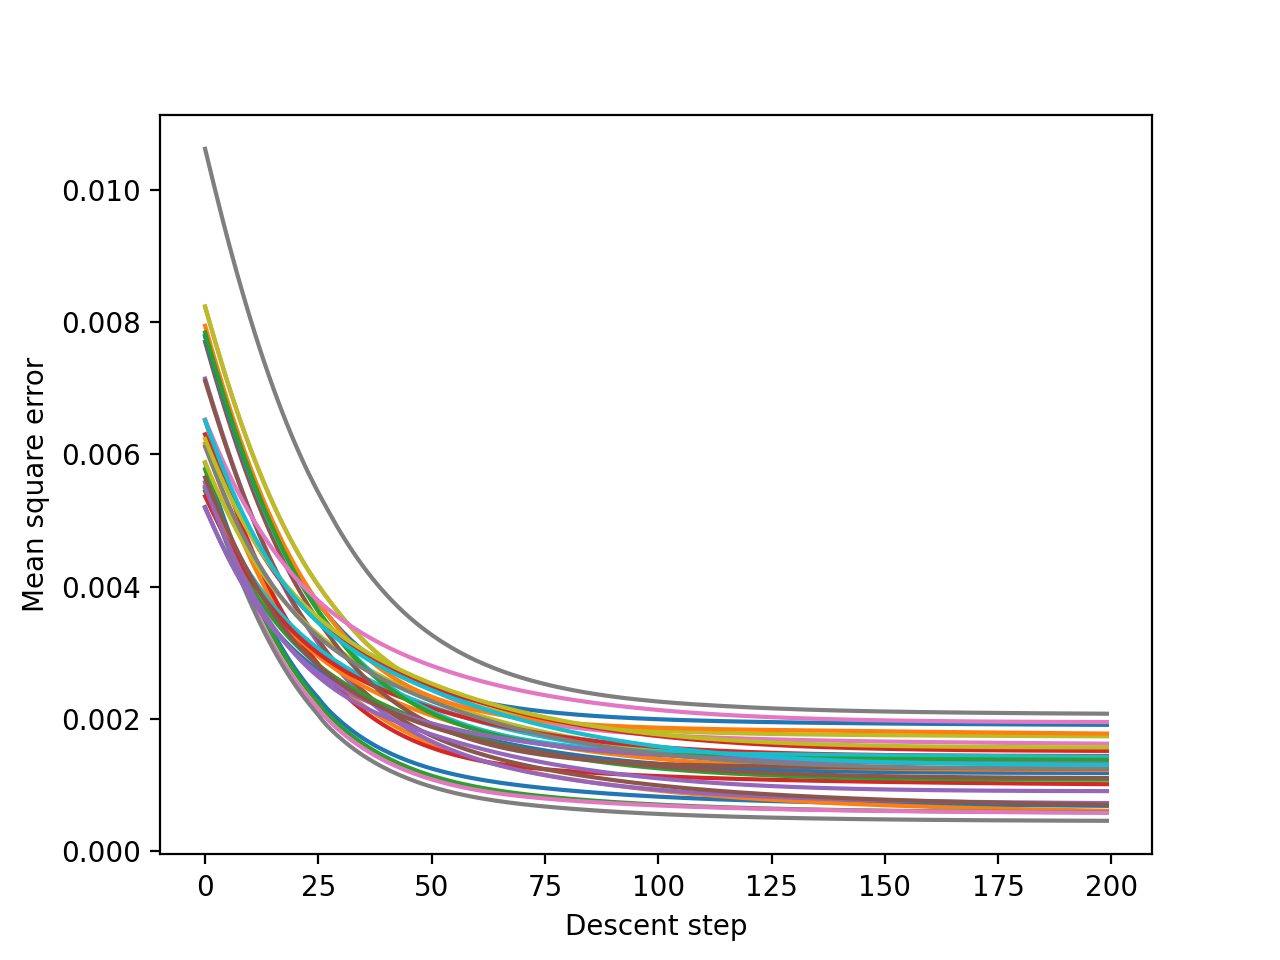

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel='Descent step', ylabel='Mean square error'>)

In [87]:
iq.plot_losses()

In [88]:
res = iq.compile_res()

### Cyt vs mem

In [225]:
mems = res.groupby('Frame').apply(lambda x: bounded_mean_1d(x['Membrane signal'], (0, 1)))
cyts = res.groupby('Frame').apply(lambda x: bounded_mean_1d(x['Cytoplasmic signal'], (0, 1)))
df = pd.DataFrame({'Mem': mems, 'Cyt': cyts, 'Condition': conditions, 'Ratio': mems / cyts})

df_filtered = df[df.Condition.isin(['wt_uni', 'gcn4_uni'])]

# fig, ax = plt.subplots()
# sns.scatterplot(data=df_filtered, x='Cyt', y='Mem', hue='Condition', ax=ax)
# ax.set_xlim(left=0)
# ax.set_ylim(bottom=0)

<IPython.core.display.Javascript object>


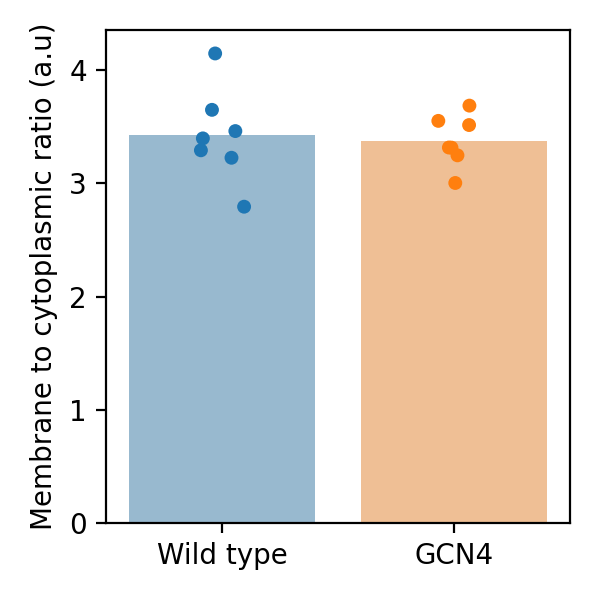

In [226]:
fig, ax = plt.subplots()
sns.barplot(data=df_filtered, x='Condition', y='Ratio', ax=ax, alpha=0.5, errwidth=0)
sns.stripplot(data=df_filtered, x='Condition', y='Ratio', ax=ax)
ax.set_xticklabels(['Wild type', 'GCN4'])
ax.set_ylabel('Membrane to cytoplasmic ratio (a.u)')
ax.set_xlabel('')
fig.set_size_inches(3, 3)
fig.tight_layout()
fig.savefig('Figs uni/ratios.png', dpi=600, transparent=True)

### Concentration profiles

In [227]:
def func(cond, ax, c):
    x = [c == cond for c in conditions]
    mems = iq.mems[x]
    mems_mean = np.mean(mems, axis=0)
    mems_std = np.std(mems, axis=0)
    ax.plot(mems_mean, c=c)
#     for i in mems:
#         ax.plot(i, c=c)
    ax.fill_between(np.arange(len(mems_mean)), mems_mean - mems_std, mems_mean + mems_std, alpha=0.2, color=c)

<IPython.core.display.Javascript object>


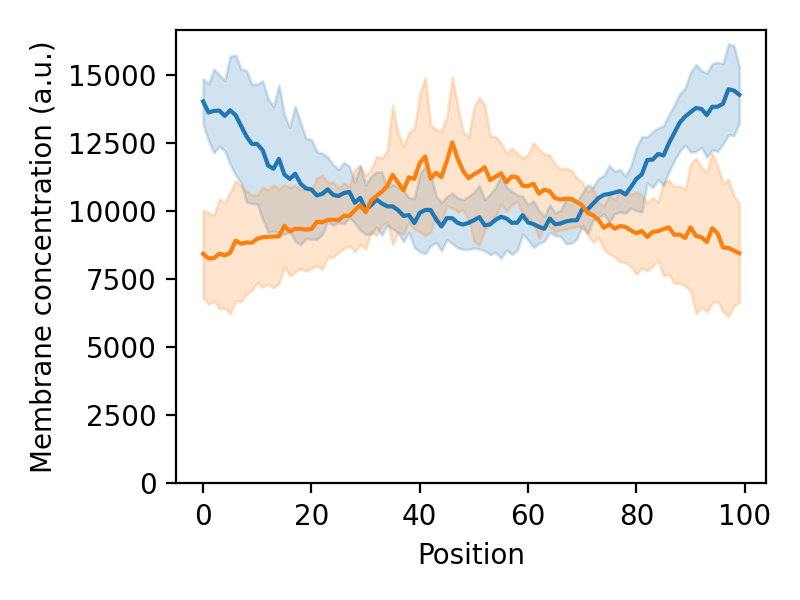

In [228]:
fig, ax = plt.subplots()
# func('wt_pol', ax)
func('wt_uni', ax, 'tab:blue')
# func('gcn4_pol', ax)
func('gcn4_uni', ax, 'tab:orange')
ax.set_ylim(bottom=0)
ax.set_xlabel('Position')
ax.set_ylabel('Membrane concentration (a.u.)')
fig.set_size_inches(4, 3)
fig.tight_layout()
fig.savefig('Figs uni/conc profiles.png', dpi=600, transparent=True)

### Cross-cortex profiles

In [229]:
wt_uni_straight = [straighten(i, r, 50, ninterp=500) for i, r in zip(wt_uni_imgs, [r for r, c in zip(
    iq.roi, conditions ) if c == 'wt_uni'])]
gcn4_uni_straight = [straighten(i, r, 50, ninterp=500) for i, r in zip(gcn4_uni_imgs, [r for r, c in zip(
    iq.roi, conditions ) if c == 'gcn4_uni'])]

In [232]:
def func(straights, ax, c):
    profs = [np.mean(s, axis=1) for s in straights]
    profs = [p / np.mean(p[450:]) for p in profs]
#     for p in profs:
#         ax.plot(p, c=c)
    profs_mean = np.mean(np.array(profs), axis=0)
    profs_std = np.std(np.array(profs), axis=0)
    ax.plot(np.linspace(0, 50, 500), profs_mean, c=c)
    ax.fill_between(np.linspace(0, 50, 500), profs_mean - profs_std, profs_mean + profs_std, alpha=0.2, color=c)

<IPython.core.display.Javascript object>


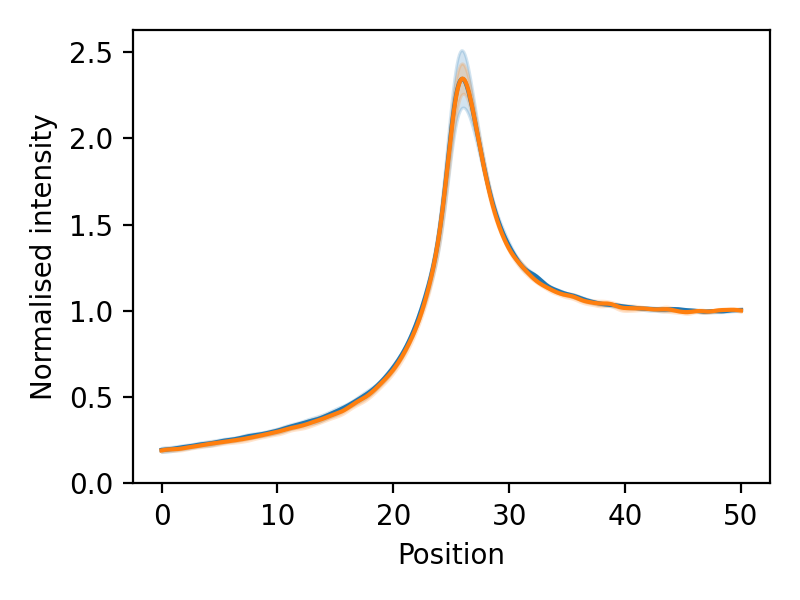

In [234]:
fig, ax = plt.subplots()
func(wt_uni_straight, ax, 'tab:blue')
func(gcn4_uni_straight, ax, 'tab:orange')
ax.set_xlabel('Position')
ax.set_ylabel('Normalised intensity')
ax.set_ylim(bottom=0)
fig.set_size_inches(4,3)
fig.tight_layout()
fig.savefig('Figs uni/cross profiles_norm.png', dpi=600, transparent=True)

### Dosage

In [235]:
def func(img, roi, expand):
    return np.nanmean(polycrop(img, roi, expand))

wt_pol_dosages = [func(i, r, 5) for i, r in zip(wt_pol_imgs, wt_pol_rois)]
wt_uni_dosages = [func(i, r, 5) for i, r in zip(wt_uni_imgs, wt_uni_rois)]
gcn4_pol_dosages = [func(i, r, 5) for i, r in zip(gcn4_pol_imgs, gcn4_pol_rois)]
gcn4_uni_dosages = [func(i, r, 5) for i, r in zip(gcn4_uni_imgs, gcn4_uni_rois)]

df = pd.DataFrame({'Condition': conditions, 
                   'Dosage': wt_pol_dosages + wt_uni_dosages + gcn4_pol_dosages + gcn4_uni_dosages})
df_filtered = df[df.Condition.isin(['wt_uni', 'gcn4_uni'])]

<IPython.core.display.Javascript object>


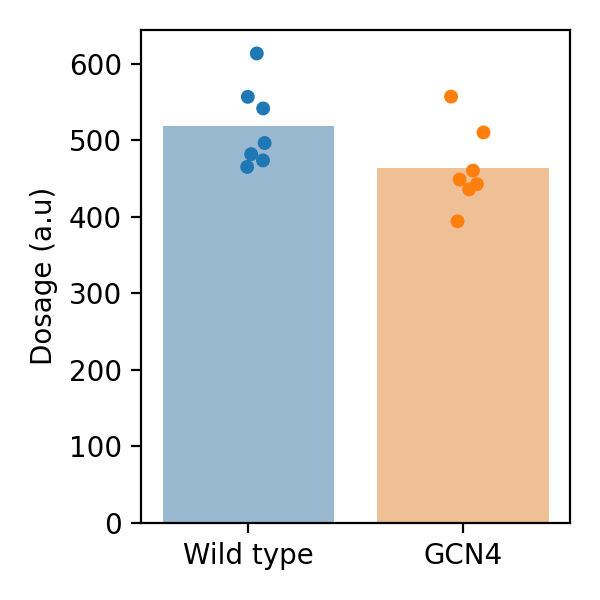

In [236]:
fig, ax = plt.subplots()
sns.barplot(data=df_filtered, x='Condition', y='Dosage', ax=ax, alpha=0.5, errwidth=0)
sns.stripplot(data=df_filtered, x='Condition', y='Dosage', ax=ax)
ax.set_xticklabels(['Wild type', 'GCN4'])
ax.set_ylabel('Dosage (a.u)')
ax.set_xlabel('')
fig.set_size_inches(3, 3)
fig.tight_layout()
fig.savefig('Figs uni/dosages.png', dpi=600, transparent=True)